In [1]:
import pandas as pd
import tensorflow as tf
from keras import models
from keras import layers
import numpy as np
from keras.models import Sequential
from keras.utils import to_categorical

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, concatenate, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model

In [2]:
from glob import glob
from PIL import Image
import os
import numpy as np
from PIL import Image

# 이미지 파일들이 저장된 디렉토리 경로
directory_pattern = "/content/drive/MyDrive/딥실 데이터셋/archive/HAM10000_images_part_*"

# 디렉토리 패턴에 맞는 모든 파일 경로 가져오기
imgPath = {os.path.splitext(os.path.basename(x))[0]: x
           for x in glob(os.path.join(directory_pattern, 'ISIC_*.jpg'))}

label_to_disease = {
    "akiec": 0,
    "bcc": 1,
    "bkl": 2,
    "df": 3,
    "nv": 4,
    "vasc": 5,
    "mel": 6
}

In [49]:
#skin_df = pd.read_csv('/content/drive/MyDrive/딥실 데이터셋/archive/HAM10000_metadata.csv')
skin_df = pd.read_pickle('/content/drive/MyDrive/딥실 데이터셋/archive/my_dataframe.pkl')

# 메타데이터에 이미지 정보 합치기
skin_df['path'] = skin_df['image_id'].map(imgPath.get)
skin_df['label'] = skin_df['dx'].map(label_to_disease)

In [50]:
skin_df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
path            0
label           0
image           0
dtype: int64

### ⬆︎ 나이만 결측치 있는 것을 확인

In [51]:
# 'age' 결측치인 부분 평균값으로 채우기
mean_age = skin_df['age'].mean()
skin_df['age'].fillna(mean_age, inplace=True)

skin_df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
path            0
label           0
image           0
dtype: int64

In [ ]:
#skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x)))

In [37]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()

# # 'age' column을 0과 1 사이의 값으로 정규화
# skin_df['age_normalized'] = scaler.fit_transform(skin_df['age'].values.reshape(-1, 1))

In [38]:
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import LabelEncoder

# one_hot_encoder_sex = OneHotEncoder()
# one_hot_encoder_local = OneHotEncoder()
# label_encoder = LabelEncoder()


# # 'sex', 'localization' column을 2차원 배열로 변환
# sex_data = skin_df['sex'].values.reshape(-1, 1)
# localization_data = skin_df['localization'].values.reshape(-1, 1)

# # 원핫 인코딩 수행
# sex_encoded = one_hot_encoder_sex.fit_transform(sex_data)
# localization_encoded = one_hot_encoder_local.fit_transform(localization_data)

# # 인코딩 결과를 데이터프레임으로 변환
# sex_columns = one_hot_encoder_sex.get_feature_names_out(['sex'])
# skin_df[sex_columns] = pd.DataFrame(sex_encoded.toarray(), columns=sex_columns)

# localization_columns = one_hot_encoder_local.get_feature_names_out(['localization'])
# skin_df[localization_columns] = pd.DataFrame(localization_encoded.toarray(), columns=localization_columns)

In [52]:
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,label,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/딥실 데이터셋/archiv...,2,"[[[191, 153, 190], [190, 152, 189], [192, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/딥실 데이터셋/archiv...,2,"[[[20, 11, 30], [20, 11, 30], [35, 21, 44], [6..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/딥실 데이터셋/archiv...,2,"[[[174, 126, 142], [186, 138, 154], [196, 145,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/딥실 데이터셋/archiv...,2,"[[[32, 6, 17], [47, 20, 29], [70, 40, 50], [91..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/MyDrive/딥실 데이터셋/archiv...,2,"[[[149, 96, 124], [163, 110, 138], [182, 129, ..."
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,/content/drive/MyDrive/딥실 데이터셋/archiv...,0,"[[[156, 139, 157], [153, 136, 154], [151, 134,..."
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,/content/drive/MyDrive/딥실 데이터셋/archiv...,0,"[[[5, 5, 0], [7, 7, 0], [16, 11, 5], [38, 31, ..."
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,/content/drive/MyDrive/딥실 데이터셋/archiv...,0,"[[[117, 103, 103], [141, 127, 127], [130, 114,..."
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,/content/drive/MyDrive/딥실 데이터셋/archiv...,0,"[[[159, 118, 136], [163, 122, 140], [168, 127,..."


In [7]:
# 데이터프레임을 pickle 파일로 저장
skin_df.to_pickle('/content/drive/MyDrive/딥실 데이터셋/archive/my_dataframe.pkl')

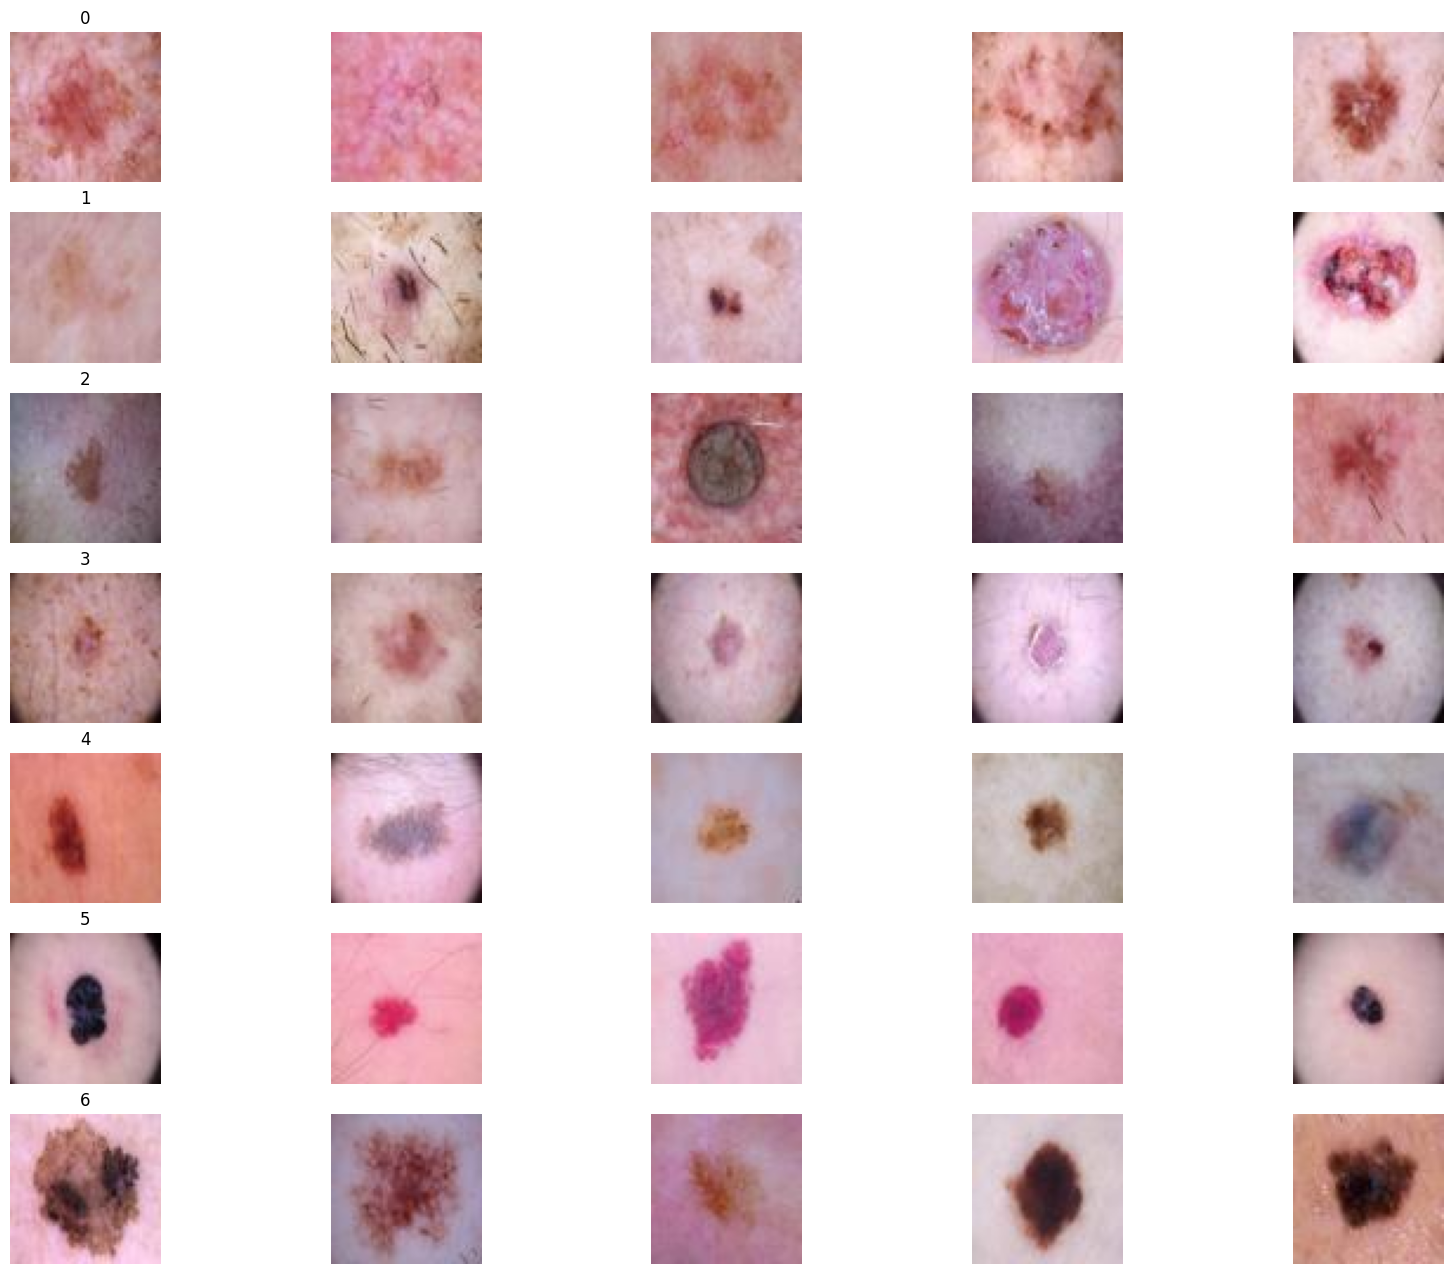

In [53]:
import matplotlib.pyplot as plt

n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 4*4))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         skin_df.sort_values(['label']).groupby('label')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [54]:
# 'label'열 맨 뒤로 옮기기
label_column = skin_df.pop('label')
skin_df.insert(len(skin_df.columns), 'label', label_column)

skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,image,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[191, 153, 190], [190, 152, 189], [192, 152,...",2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[20, 11, 30], [20, 11, 30], [35, 21, 44], [6...",2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[174, 126, 142], [186, 138, 154], [196, 145,...",2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[32, 6, 17], [47, 20, 29], [70, 40, 50], [91...",2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[149, 96, 124], [163, 110, 138], [182, 129, ...",2
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[156, 139, 157], [153, 136, 154], [151, 134,...",0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[5, 5, 0], [7, 7, 0], [16, 11, 5], [38, 31, ...",0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[117, 103, 103], [141, 127, 127], [130, 114,...",0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[159, 118, 136], [163, 122, 140], [168, 127,...",0


# 데이터 증강 ... 데이터 부족한 애들 약 1000개로 맞춤

In [55]:
# 이미지 증강
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=60,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)

In [56]:
# 증강 필요한 질병 데이터
vasc_df_data = skin_df[(skin_df['label'] == 3) | (skin_df['label'] == 5)]

akiec_data = skin_df[skin_df['label'] == 0]

bcc_data = skin_df[skin_df['label'] == 1]

## df랑 vasc(제일 데이터 작은 애들...100개) 10배 증강

In [57]:
augmented_vasc_df = pd.DataFrame(columns=skin_df.columns)

for i in range(len(vasc_df_data)):
    image_row = vasc_df_data.iloc[i]
    image = image_row['image']
    other_data = image_row.drop('image')

    for j in range(10):
        augmented_image = datagen.random_transform(image)  # 이미지 증강

        augmented_metadata = other_data.copy()
        augmented_metadata['image'] = augmented_image
        augmented_vasc_df.loc[i*10 + j] = augmented_metadata

# 데이터 합치기
augmented_vasc_df = pd.concat([vasc_df_data, augmented_vasc_df], axis=0)

augmented_vasc_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,image,label
1095,HAM_0005276,ISIC_0027008,df,histo,75.0,male,back,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[156, 111, 106], [175, 130, 125], [189, 145,...",3
1096,HAM_0005276,ISIC_0028790,df,histo,75.0,male,back,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[204, 162, 176], [207, 165, 177], [217, 171,...",3
1097,HAM_0004103,ISIC_0028880,df,histo,55.0,male,lower extremity,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[218, 189, 220], [217, 188, 219], [220, 191,...",3
1098,HAM_0004103,ISIC_0031309,df,histo,55.0,male,lower extremity,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[41, 15, 24], [64, 38, 47], [97, 71, 80], [1...",3
1099,HAM_0001164,ISIC_0030021,df,histo,50.0,female,upper extremity,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[196, 153, 160], [198, 155, 162], [201, 158,...",3
...,...,...,...,...,...,...,...,...,...,...
2565,HAM_0005560,ISIC_0027269,vasc,consensus,60.0,female,trunk,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[241, 197, 222], [240, 196, 221], [240, 196,...",5
2566,HAM_0005560,ISIC_0027269,vasc,consensus,60.0,female,trunk,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[239, 193, 212], [240, 193, 213], [241, 194,...",5
2567,HAM_0005560,ISIC_0027269,vasc,consensus,60.0,female,trunk,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[230, 196, 210], [230, 196, 210], [230, 196,...",5
2568,HAM_0005560,ISIC_0027269,vasc,consensus,60.0,female,trunk,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[236, 189, 210], [234, 190, 211], [232, 190,...",5


## akiec 4배 증강 ... 327개

In [58]:
augmented_akiec = pd.DataFrame(columns=skin_df.columns)

for i in range(len(akiec_data)):
    image_row = akiec_data.iloc[i]
    image = image_row['image']
    other_data = image_row.drop('image')

    for j in range(4):
        augmented_image = datagen.random_transform(image)  # 이미지 증강

        augmented_metadata = other_data.copy()
        augmented_metadata['image'] = augmented_image
        augmented_akiec.loc[i*4 + j] = augmented_metadata

#1308
augmented_akiec = pd.concat([akiec_data, augmented_akiec], axis=0)

## bcc 2배 증강 ... 500개

In [59]:
augmented_bcc = pd.DataFrame(columns=skin_df.columns)

for i in range(len(bcc_data)):
    image_row = bcc_data.iloc[i]
    image = image_row['image']
    other_data = image_row.drop('image')

    for j in range(2):
        augmented_image = datagen.random_transform(image)  # 이미지 증강

        augmented_metadata = other_data.copy()
        augmented_metadata['image'] = augmented_image
        augmented_bcc.loc[i*2 + j] = augmented_metadata

# 결과 확인
augmented_bcc = pd.concat([bcc_data, augmented_bcc], axis=0)

In [60]:
merged_df = pd.concat([skin_df , augmented_vasc_df, augmented_akiec, augmented_bcc], ignore_index=True)

merged_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,image,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[191, 153, 190], [190, 152, 189], [192, 152,...",2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[20, 11, 30], [20, 11, 30], [35, 21, 44], [6...",2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[174, 126, 142], [186, 138, 154], [196, 145,...",2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[32, 6, 17], [47, 20, 29], [70, 40, 50], [91...",2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[149, 96, 124], [163, 110, 138], [182, 129, ...",2
...,...,...,...,...,...,...,...,...,...,...
16014,HAM_0001215,ISIC_0031531,bcc,histo,70.0,male,back,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[149, 116, 112], [150, 117, 113], [151, 117,...",1
16015,HAM_0005026,ISIC_0028978,bcc,histo,40.0,female,abdomen,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[212, 180, 185], [212, 180, 185], [210, 178,...",1
16016,HAM_0005026,ISIC_0028978,bcc,histo,40.0,female,abdomen,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[187, 159, 158], [192, 163, 164], [195, 166,...",1
16017,HAM_0005026,ISIC_0028728,bcc,histo,40.0,female,abdomen,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[213, 167, 177], [212, 166, 176], [211, 166,...",1


## 이미지 증강 및 데이터 합치기 끝

In [61]:
import numpy as np

for i in range(merged_df.shape[0]):
    merged_df.at[i, 'image'] = merged_df.at[i, 'image'].astype('float32') / 255

merged_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,image,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[0.7490196, 0.6, 0.74509805], [0.74509805, 0...",2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[0.078431375, 0.043137256, 0.11764706], [0.0...",2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[0.68235296, 0.49411765, 0.5568628], [0.7294...",2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[0.1254902, 0.023529412, 0.06666667], [0.184...",2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[0.58431375, 0.3764706, 0.4862745], [0.63921...",2
...,...,...,...,...,...,...,...,...,...,...
16014,HAM_0001215,ISIC_0031531,bcc,histo,70.0,male,back,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[0.58431375, 0.45490196, 0.4392157], [0.5882...",1
16015,HAM_0005026,ISIC_0028978,bcc,histo,40.0,female,abdomen,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[0.83137256, 0.7058824, 0.7254902], [0.83137...",1
16016,HAM_0005026,ISIC_0028978,bcc,histo,40.0,female,abdomen,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[0.73333335, 0.62352943, 0.61960787], [0.752...",1
16017,HAM_0005026,ISIC_0028728,bcc,histo,40.0,female,abdomen,/content/drive/MyDrive/딥실 데이터셋/archiv...,"[[[0.8352941, 0.654902, 0.69411767], [0.831372...",1


In [62]:
inputs = merged_df[['age', 'sex', 'localization', 'image']]
labels= merged_df['label']

type(inputs)

pandas.core.frame.DataFrame

## 순서 섞기

In [63]:
# DataFrame을 NumPy 배열로 변환
inputs_np = inputs.values

# 배열의 인덱스를 무작위로 섞음
idx = np.random.permutation(len(inputs_np))

# 섞인 인덱스를 사용하여 배열을 섞음
inputs, labels = inputs_np[idx], labels[idx]

type(inputs)

numpy.ndarray

In [ ]:
# idx = np.random.permutation(len(inputs))
# inputs, labels = inputs[idx], labels[idx]

In [64]:
inputs[0][3]

array([[[0.6862745 , 0.63529414, 0.7019608 ],
        [0.6784314 , 0.627451  , 0.69411767],
        [0.6901961 , 0.6392157 , 0.7058824 ],
        ...,
        [0.7058824 , 0.654902  , 0.69411767],
        [0.72156864, 0.67058825, 0.70980394],
        [0.7294118 , 0.6784314 , 0.7176471 ]],

       [[0.69803923, 0.64705884, 0.7137255 ],
        [0.6901961 , 0.6392157 , 0.7058824 ],
        [0.69803923, 0.64705884, 0.7137255 ],
        ...,
        [0.7058824 , 0.654902  , 0.69411767],
        [0.7137255 , 0.6627451 , 0.7019608 ],
        [0.7176471 , 0.6666667 , 0.7058824 ]],

       [[0.7137255 , 0.6627451 , 0.7294118 ],
        [0.7019608 , 0.6509804 , 0.7176471 ],
        [0.7058824 , 0.654902  , 0.72156864],
        ...,
        [0.7058824 , 0.654902  , 0.69411767],
        [0.7058824 , 0.654902  , 0.69411767],
        [0.7019608 , 0.6509804 , 0.6901961 ]],

       ...,

       [[0.69803923, 0.654902  , 0.70980394],
        [0.6901961 , 0.64705884, 0.7019608 ],
        [0.68235296, 0

In [83]:
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.3,random_state=42)

In [84]:
inputs[0][3].shape

(64, 64, 3)

In [85]:
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

In [86]:
# 이미지 입력 레이어
image_input = Input(shape=(64, 64, 3), name='image_input')
conv1 = Conv2D(32, (3, 3), activation='relu')(image_input)
conv1 = BatchNormalization()(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu')(conv1)
conv2 = BatchNormalization()(conv2)
pool1 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu')(pool1)
conv3 = BatchNormalization()(conv3)
pool2 = MaxPooling2D((2, 2))(conv3)
image = Flatten()(pool2)

# 나이 입력 레이어
age_input = Input(shape=(1,), name='age_input')

# 성별 입력 레이어
sex_input = Input(shape=(3,), name='sex_input')

# 발병 위치 입력 레이어
localization_input = Input(shape=(15,), name='localization_input')

# 위 입력 다 병합
multi_input = concatenate([image, age_input, sex_input, localization_input])

dense1 = Dense(256, activation='relu')(multi_input)
dropout1 = Dropout(0.5)(dense1)

# 출력 레이어 (7가지로 분류)
output = Dense(7, activation='softmax')(dropout1)

# 모델 생성
model = Model(inputs=[image_input, age_input, sex_input, localization_input], outputs=output)

from keras.optimizers import Adam
Adam_custom = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999) # epsilon=None, amsgrad=False

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 요약 출력
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 62, 62, 32)           896       ['image_input[0][0]']         
                                                                                                  
 batch_normalization_6 (Bat  (None, 62, 62, 32)           128       ['conv2d_6[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 conv2d_7 (Conv2D)           (None, 60, 60, 64)           18496     ['batch_normalization_6[

In [92]:
X_train_image = X_train[:, 3]
X_train_age = X_train[:, 0]
X_train_sex = X_train[:, 1]
X_train_localization = X_train[:, 2]

X_test_image = X_test[:, 3]
X_test_age = X_test[:, 0]
X_test_sex = X_test[:, 1]
X_test_localization = X_test[:, 2]

# y_train을 원-핫 인코딩
y_train_encoded = to_categorical(y_train, num_classes=7)

print(type(X_train_image))
print(type(X_train_age))
print(type(X_train_sex))
print(type(X_train_localization))
print(type(y_train_encoded))
print(X_train_sex.shape)
print(X_test_sex.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(11213,)
(4806,)


In [93]:
label_encoder_sex = LabelEncoder()
onehot_encoder_sex = OneHotEncoder()

train_labels_sex = label_encoder_sex.fit_transform(X_train_sex)
X_train_sex_one_hot = onehot_encoder_sex.fit_transform(train_labels_sex.reshape(-1, 1))

test_labels_sex = label_encoder_sex.fit_transform(X_test_sex)
X_test_sex_one_hot = onehot_encoder_sex.fit_transform(test_labels_sex.reshape(-1, 1))

print(X_train_sex_one_hot.shape)
print(X_test_sex_one_hot.shape)

(11213, 3)
(4806, 3)


In [96]:
label_encoder_localization = LabelEncoder()
onehot_encoder_localization = OneHotEncoder()

localization_train_labels = label_encoder_localization.fit_transform(X_train_localization)
X_train_localization_one_hot = onehot_encoder_localization.fit_transform(localization_train_labels.reshape(-1, 1))

localization_test_labels = label_encoder_localization.fit_transform(X_test_localization)
X_test_localization_one_hot = onehot_encoder_localization.fit_transform(localization_test_labels.reshape(-1, 1))

print(X_train_localization_one_hot.shape)
print(X_test_localization_one_hot.shape)

(11213, 15)
(4806, 15)


In [102]:
# 이미지 데이터를 넘파이 배열로 변환
X_train_image_np = np.array([np.array(image) for image in X_train_image])
X_test_image_np = np.array([np.array(image) for image in X_test_image])

X_train_age_np = np.array([np.array(age) for age in X_train_age])
X_test_age_np = np.array([np.array(age) for age in X_test_age])

X_train_sex_one_hot_np = X_train_sex_one_hot.toarray()
X_test_sex_one_hot_np = X_test_sex_one_hot.toarray()

X_train_localization_one_hot_np = X_train_localized_one_hot.toarray()
X_test_localization_one_hot = X_test_localization_one_hot.toarray()

# 이미지 데이터의 형태 확인
print("이미지 데이터의 형태:", X_test_image.shape)
print("이미지 데이터의 타입:", type(X_train_image_np))

print("y 데이터의 형태:", y_train.shape)
print("y 데이터의 타입:", type(y_train))

print("이미지 데이터의 타입:", type(X_train_image_np))
print("나이 데이터의 타입:", type(X_train_age_np))
print("성별 데이터의 타입:", type(X_train_sex_one_hot_np))
print("발병 위치 데이터의 타입:", type(X_train_localization_one_hot_np))
print("y 데이터의 타입:", type(y_train))

이미지 데이터의 형태: (4806,)
이미지 데이터의 타입: <class 'numpy.ndarray'>
y 데이터의 형태: (11213, 7)
y 데이터의 타입: <class 'numpy.ndarray'>
이미지 데이터의 타입: <class 'numpy.ndarray'>
나이 데이터의 타입: <class 'numpy.ndarray'>
성별 데이터의 타입: <class 'numpy.ndarray'>
발병 위치 데이터의 타입: <class 'numpy.ndarray'>
y 데이터의 타입: <class 'numpy.ndarray'>


In [103]:
# 모델을 훈련시킴
history = model.fit([X_train_image_np, X_train_age_np, X_train_sex_one_hot_np, X_train_localization_one_hot_np], y_train,
                    epochs=30,
                    batch_size=64,
                    validation_split=0.2)

Epoch 1/30
141/141 [==============================] - 5s 35ms/step - loss: 0.2800 - accuracy: 0.8957 - val_loss: 1.3306 - val_accuracy: 0.6188
Epoch 2/30
141/141 [==============================] - 5s 33ms/step - loss: 0.2797 - accuracy: 0.8910 - val_loss: 2.0042 - val_accuracy: 0.6723
Epoch 3/30
141/141 [==============================] - 5s 34ms/step - loss: 0.2451 - accuracy: 0.9055 - val_loss: 1.3136 - val_accuracy: 0.6924
Epoch 4/30
141/141 [==============================] - 5s 35ms/step - loss: 0.2281 - accuracy: 0.9086 - val_loss: 1.9933 - val_accuracy: 0.6103
Epoch 5/30
141/141 [==============================] - 4s 31ms/step - loss: 0.2306 - accuracy: 0.9119 - val_loss: 1.2173 - val_accuracy: 0.7044
Epoch 6/30
141/141 [==============================] - 4s 32ms/step - loss: 0.2121 - accuracy: 0.9151 - val_loss: 1.2724 - val_accuracy: 0.7191
Epoch 7/30
141/141 [==============================] - 5s 32ms/step - loss: 0.2004 - accuracy: 0.9213 - val_loss: 3.3916 - val_accuracy: 0.5724

In [105]:
loss, acc = model.evaluate([X_test_image_np, X_test_age_np, X_test_sex_one_hot_np, X_test_localization_one_hot], y_test, verbose=1)

print("Test: accuracy = %f  ;  loss = %f" % (acc, loss))

151/151 [==============================] - 2s 9ms/step - loss: 1.3509 - accuracy: 0.7382
Test: accuracy = 0.738244  ;  loss = 1.350875
